### Library

In [1]:
import os
import time
import random
import timm
import torch
import cv2
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shutil
import wandb
warnings.filterwarnings('ignore')

from albumentations import Compose, RandomBrightnessContrast, Blur, ShiftScaleRotate, GaussNoise, RandomGamma, CLAHE
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from augraphy import Pipeline
from augraphy.augmentations import (
    BrightnessTexturize,
    DirtyDrum,
    DirtyRollers,
    Fold,
    JpegCompression,
    LowInkRandomLines,
    NoiseTexturize,
    PrintSpeckles,
    SubtleNoise,
    PerspectiveTransform,
)

ImportError: cannot import name 'Pipeline' from 'augraphy' (/opt/conda/envs/CV_Project/lib/python3.9/site-packages/augraphy/__init__.py)

In [ ]:
def random_seed(SEED=42):
    # SEED = 42 # default
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

random_seed()

### Load Data

In [2]:
train_csv = "../data/train.csv"
inference_csv = "../data/sample_submission.csv"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(inference_csv)

print(f"Train Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}")

Train Data: (1570, 2)
Test Data: (3140, 2)


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "convnextv2_large.fcmae_ft_in22k_in1k"  
img_size = 224 
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 16
Drop_out = 0.3
num_workers = 2 # GPU 사용

In [4]:
class ImageDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df.values 
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [6]:
train_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),   # 1) 이미지 크기 통일
    A.Normalize(                                 # 2) 픽셀 정규화
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),                                # 3) 텐서 변환
])

test_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),   # 1) 이미지 크기 통일
    A.Normalize(                                 # 2) 픽셀 정규화
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),                                # 3) 텐서 변환
])

train_path = '../../data/train/'
test_path = '../../data/test/'

train_dataset = ImageDataset(train_df, train_path, transform=train_transform)
test_dataset = ImageDataset(test_df, test_path, transform=test_transform)

In [7]:
# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count'):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=col, palette=palette)
    plt.title(title if title else f'{col} Count')
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    plt.show()

# hist plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, 
              color1='skyblue', color2='salmon', label1=None, label2=None, 
              title=None, density=False):
    plt.figure(figsize=figsize)
    
    stat_mode = 'density' if density else 'count'

    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, 
                 stat=stat_mode, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None:
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, 
                     stat=stat_mode, label=label2 if label2 else 'Group 2')
        plt.legend()

    plt.title(title if title else f'{col} Distribution ({"Density" if density else "Count"} Histogram + KDE)')
    plt.xlabel(col)
    plt.ylabel("Density" if density else "Count")
    plt.show()

# bar plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

# heatmap
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])
        
        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

### Preprocessing

In [ ]:
def full_augmentation(train_df, train_path, save_dir, augmentation, per_class_target):
    os.makedirs(save_dir, exist_ok=True)
    augmented_records = []

    # 원본 데이터 모두 복사
    print(f"[INFO] 원본 {len(train_df)}개 복사 중...")
    for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
        img_name, target = row['ID'], row['target']
        src = os.path.join(train_path, img_name)
        dst = os.path.join(save_dir, img_name)
        shutil.copy2(src, dst)
        augmented_records.append({"ID": img_name, "target": target})

    # 클래스별 목표 개수까지 증강
    for target_class in sorted(train_df['target'].unique()):
        class_df = train_df[train_df["target"] == target_class]
        current_count = len(class_df)

        if current_count >= per_class_target:
            print(f"[INFO] Class {target_class}: 이미 {current_count}개로 목표 달성")
            continue

        n_to_augment = per_class_target - current_count
        print(f"[INFO] Class {target_class}: {current_count}개 → {per_class_target}개로 증강 중...")

        for i in tqdm(range(n_to_augment)):
            sample_row = class_df.sample(1).iloc[0]
            img_name = sample_row['ID']
            img_path = os.path.join(train_path, img_name)

            img = cv2.imread(img_path)
            if img is None:
                print(f"[경고] 이미지 로드 실패: {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented = augmentation(image=img)['image']

            aug_name = f"aug_class{target_class}_{i}_{img_name}"
            aug_path = os.path.join(save_dir, aug_name)
            cv2.imwrite(aug_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
            augmented_records.append({"ID": aug_name, "target": target_class})

    # 증강 정보 CSV 저장
    aug_df = pd.DataFrame(augmented_records)
    aug_df.to_csv("../../data/V3-augmented.csv", index=False)
    print("[완료] 원본 + 증강 데이터 저장 완료")

In [ ]:
augmentation = A.Compose([
    A.RandomResizedCrop(size=(img_size, img_size), scale=(0.9, 1.0), p=0.2),

    A.RandomBrightnessContrast(limit=0.1, p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.2),

    A.Blur(blur_limit=2, p=0.2),
    A.MotionBlur(blur_limit=5, p=0.2),
    A.Defocus(radius=(1, 3), p=0.2),

    A.Perspective(scale=(0.05, 0.1), keep_size=True, p=0.2),
    A.Affine(shear={"x": (-10, 10), "y": (-10, 10)}, p=0.2),

    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=5, p=0.2),
    A.OneOf([
        A.Rotate(limit=[-90, 90], p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
    ], p=0.2),

    A.GaussNoise(var_limit=(0.0001, 0.002), mean=0, p=0.2),
    A.ImageCompression(quality_lower=30, quality_upper=70, p=0.2),
    A.CLAHE(clip_limit=1.5, p=0.2),
    A.CoarseDropout(max_holes=8, max_height=img_size//10, max_width=img_size//10, p=0.2),
])

save_dir = "../../data/V3-augmented"
per_class_target = 200  # 각 클래스당 200개로 통일

full_augmentation(train_df, train_path, save_dir, augmentation, per_class_target)

[INFO] 원본 1570개 복사 중...


100%|██████████| 1570/1570 [00:00<00:00, 5814.76it/s]


[INFO] Class 0: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 172.74it/s]


[INFO] Class 1: 46개 → 200개로 증강 중...


100%|██████████| 154/154 [00:00<00:00, 221.87it/s]


[INFO] Class 2: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 223.39it/s]


[INFO] Class 3: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 230.45it/s]


[INFO] Class 4: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 220.92it/s]


[INFO] Class 5: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 235.89it/s]


[INFO] Class 6: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 204.77it/s]


[INFO] Class 7: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 249.04it/s]


[INFO] Class 8: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 220.85it/s]


[INFO] Class 9: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 223.38it/s]


[INFO] Class 10: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 194.16it/s]


[INFO] Class 11: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 221.36it/s]


[INFO] Class 12: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 229.29it/s]


[INFO] Class 13: 74개 → 200개로 증강 중...


100%|██████████| 126/126 [00:00<00:00, 202.49it/s]


[INFO] Class 14: 50개 → 200개로 증강 중...


100%|██████████| 150/150 [00:00<00:00, 229.06it/s]


[INFO] Class 15: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 258.09it/s]


[INFO] Class 16: 100개 → 200개로 증강 중...


100%|██████████| 100/100 [00:00<00:00, 201.24it/s]

[완료] 원본 + 증강 데이터 저장 완료


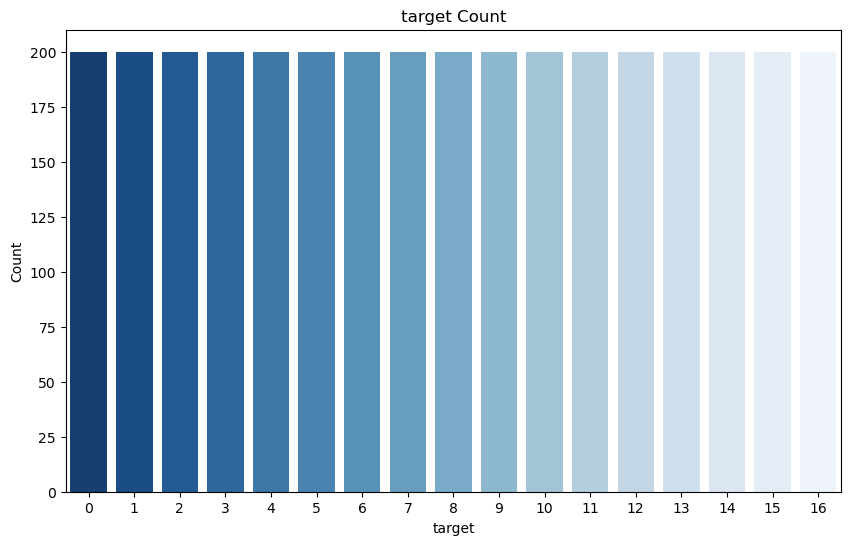

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16
...,...,...
3395,aug_class16_95_a9c98518ff83cd43.jpg,16
3396,aug_class16_96_00f59b12e9e08f29.jpg,16
3397,aug_class16_97_8b3b6ef2484a4535.jpg,16
3398,aug_class16_98_785860603a570231.jpg,16


In [ ]:
# Class check
aug_df = pd.read_csv("../data/Full_augmented.csv")
count_plot(df=aug_df, col='target')
aug_df

In [ ]:
# StratifiedKFold 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(aug_df, aug_df['target'])):
    print(f"\n=== Fold {fold+1} ===")
    train_fold_df = aug_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = aug_df.iloc[val_idx].reset_index(drop=True)

    train_dataset = ImageDataset(train_fold_df, path="../data/Full_augmented", transform=train_transform)
    val_dataset = ImageDataset(val_fold_df, path="../data/Full_augmented", transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
    print(f"Fold {fold+1}: Train samples={len(train_fold_df)}, Val samples={len(val_fold_df)}")

    # 모델 정의
    model = timm.create_model(model_name, pretrained=True, num_classes=17, drop_path_rate=Drop_out).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_f1 = -1.0
    patience = 5
    trigger = 0

    os.environ["WANDB_DIR"] = "../../"

    wandb.init(
    project="Document Classification",
    entity="moonstalker9010-none",
    name=f"V2-fold_{fold+1}",
    config={
        "epochs": EPOCHS,
        "img_size": img_size,
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "Drop_out": Drop_out,
        "model_name": model_name,
        "train_samples": len(train_fold_df),
        "val_samples": len(val_fold_df),
    }
)
    
    wandb.log({
    "Train_Data": len(train_fold_df),
    "Val_Data": len(val_fold_df),
})

    for epoch in range(1, EPOCHS + 1):
        # 학습
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"[Fold {fold+1}][Epoch {epoch}/{EPOCHS}] Training")
        for images, targets in train_bar:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)

        # 검증
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"[Fold {fold+1}][Epoch {epoch}/{EPOCHS}] Validation")
            for images, targets in val_bar:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

                correct += (preds == targets).sum().item()
                total += targets.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_f1 = f1_score(all_targets, all_preds, average='macro')

        print(f"[F{fold+1}] Ep{epoch} - "
              f"Train: {avg_train_loss:.4f} | VaL: {avg_val_loss:.4f}, "
              f"Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        wandb.log({
            "fold": fold + 1,
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_acc": val_acc,
            "val_f1": val_f1,
        })

        # EarlyStopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            trigger = 0
            save_dir = "../model"
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_fold{fold+1}.pth"))
        else:
            trigger += 1
            if trigger >= patience:
                print(f"[Fold {fold+1}] Early stopping triggered. Best F1: {best_f1:.4f}")
                break

    wandb.finish()


=== Fold 1 ===
Fold 1: Train samples=2720, Val samples=680


wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[Fold 1][Epoch 1/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.78it/s]


[F1] Ep1 - Train: 0.6268 | VaL: 0.2769, Acc: 0.8912, F1: 0.8831


[Fold 1][Epoch 2/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.65it/s]


[F1] Ep2 - Train: 0.1709 | VaL: 0.1499, Acc: 0.9500, F1: 0.9502


[Fold 1][Epoch 3/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.71it/s]


[F1] Ep3 - Train: 0.1267 | VaL: 0.1253, Acc: 0.9618, F1: 0.9614


[Fold 1][Epoch 4/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.68it/s]


[F1] Ep4 - Train: 0.0791 | VaL: 0.0909, Acc: 0.9647, F1: 0.9646


[Fold 1][Epoch 5/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.75it/s]


[F1] Ep5 - Train: 0.0400 | VaL: 0.1294, Acc: 0.9515, F1: 0.9534


[Fold 1][Epoch 6/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.49it/s]


[F1] Ep6 - Train: 0.0542 | VaL: 0.2660, Acc: 0.9265, F1: 0.9273


[Fold 1][Epoch 7/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.63it/s]


[F1] Ep7 - Train: 0.0572 | VaL: 0.1158, Acc: 0.9544, F1: 0.9549


[Fold 1][Epoch 8/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.77it/s]


[F1] Ep8 - Train: 0.0388 | VaL: 0.0996, Acc: 0.9809, F1: 0.9808


[Fold 1][Epoch 9/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.83it/s]


[F1] Ep9 - Train: 0.0249 | VaL: 0.1575, Acc: 0.9603, F1: 0.9597


[Fold 1][Epoch 10/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.63it/s]


[F1] Ep10 - Train: 0.0426 | VaL: 0.1288, Acc: 0.9647, F1: 0.9654


[Fold 1][Epoch 11/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.72it/s]


[F1] Ep11 - Train: 0.0323 | VaL: 0.0969, Acc: 0.9765, F1: 0.9762


[Fold 1][Epoch 12/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.82it/s]


[F1] Ep12 - Train: 0.0358 | VaL: 0.1095, Acc: 0.9750, F1: 0.9751


[Fold 1][Epoch 13/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.56it/s]

[F1] Ep13 - Train: 0.0127 | VaL: 0.1021, Acc: 0.9779, F1: 0.9776
[Fold 1] Early stopping triggered. Best F1: 0.9808


Train_Data,▁
Val_Data,▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▁▁▂▁▁▁▁▁▁
val_acc,▁▆▇▇▆▄▆█▆▇███
val_f1,▁▆▇▇▆▄▆█▆▇███
val_loss,█▃▂▁▂█▂▁▄▂▁▂▁
Train_Data,2720
Val_Data,680
epoch,13



=== Fold 2 ===
Fold 2: Train samples=2720, Val samples=680


[Fold 2][Epoch 1/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.49it/s]


[F2] Ep1 - Train: 0.6658 | VaL: 0.1818, Acc: 0.9368, F1: 0.9364


[Fold 2][Epoch 2/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.74it/s]


[F2] Ep2 - Train: 0.1852 | VaL: 0.2527, Acc: 0.9147, F1: 0.9134


[Fold 2][Epoch 3/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.85it/s]


[F2] Ep3 - Train: 0.0987 | VaL: 0.1366, Acc: 0.9544, F1: 0.9542


[Fold 2][Epoch 4/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.75it/s]


[F2] Ep4 - Train: 0.1081 | VaL: 0.1642, Acc: 0.9574, F1: 0.9566


[Fold 2][Epoch 5/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.85it/s]


[F2] Ep5 - Train: 0.0694 | VaL: 0.1206, Acc: 0.9721, F1: 0.9721


[Fold 2][Epoch 6/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.84it/s]


[F2] Ep6 - Train: 0.0533 | VaL: 0.1177, Acc: 0.9676, F1: 0.9676


[Fold 2][Epoch 7/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.60it/s]


[F2] Ep7 - Train: 0.0391 | VaL: 0.1318, Acc: 0.9647, F1: 0.9658


[Fold 2][Epoch 8/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.86it/s]


[F2] Ep8 - Train: 0.0634 | VaL: 0.2479, Acc: 0.9456, F1: 0.9468


[Fold 2][Epoch 9/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.85it/s]


[F2] Ep9 - Train: 0.0478 | VaL: 0.1168, Acc: 0.9721, F1: 0.9719


[Fold 2][Epoch 10/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.68it/s]


[F2] Ep10 - Train: 0.0251 | VaL: 0.1033, Acc: 0.9779, F1: 0.9780


[Fold 2][Epoch 11/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.75it/s]


[F2] Ep11 - Train: 0.0121 | VaL: 0.1249, Acc: 0.9750, F1: 0.9748


[Fold 2][Epoch 12/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.80it/s]


[F2] Ep12 - Train: 0.0414 | VaL: 0.1399, Acc: 0.9647, F1: 0.9651


[Fold 2][Epoch 13/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.72it/s]


[F2] Ep13 - Train: 0.0130 | VaL: 0.1811, Acc: 0.9706, F1: 0.9700


[Fold 2][Epoch 14/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.57it/s]


[F2] Ep14 - Train: 0.0405 | VaL: 0.1377, Acc: 0.9662, F1: 0.9662


[Fold 2][Epoch 15/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.63it/s]

[F2] Ep15 - Train: 0.0132 | VaL: 0.1936, Acc: 0.9529, F1: 0.9525
[Fold 2] Early stopping triggered. Best F1: 0.9780


Train_Data,▁
Val_Data,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▂▁▁▁▁▁▁▁
val_acc,▃▁▅▆▇▇▇▄▇██▇▇▇▅
val_f1,▃▁▅▆▇▇▇▅▇██▇▇▇▅
val_loss,▅█▃▄▂▂▂█▂▁▂▃▅▃▅
Train_Data,2720
Val_Data,680
epoch,15



=== Fold 3 ===
Fold 3: Train samples=2720, Val samples=680


[Fold 3][Epoch 1/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.70it/s]


[F3] Ep1 - Train: 0.7307 | VaL: 0.2311, Acc: 0.9118, F1: 0.9064


[Fold 3][Epoch 2/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.60it/s]


[F3] Ep2 - Train: 0.1822 | VaL: 0.1412, Acc: 0.9500, F1: 0.9483


[Fold 3][Epoch 3/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.80it/s]


[F3] Ep3 - Train: 0.1299 | VaL: 0.1895, Acc: 0.9368, F1: 0.9353


[Fold 3][Epoch 4/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.77it/s]


[F3] Ep4 - Train: 0.0799 | VaL: 0.1452, Acc: 0.9500, F1: 0.9495


[Fold 3][Epoch 5/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.68it/s]


[F3] Ep5 - Train: 0.0652 | VaL: 0.1313, Acc: 0.9647, F1: 0.9648


[Fold 3][Epoch 6/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.63it/s]


[F3] Ep6 - Train: 0.0522 | VaL: 0.1709, Acc: 0.9544, F1: 0.9538


[Fold 3][Epoch 7/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.82it/s]


[F3] Ep7 - Train: 0.0393 | VaL: 0.1449, Acc: 0.9662, F1: 0.9663


[Fold 3][Epoch 8/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.73it/s]


[F3] Ep8 - Train: 0.0364 | VaL: 0.1596, Acc: 0.9588, F1: 0.9584


[Fold 3][Epoch 9/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.62it/s]


[F3] Ep9 - Train: 0.0577 | VaL: 0.1170, Acc: 0.9662, F1: 0.9671


[Fold 3][Epoch 10/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.82it/s]


[F3] Ep10 - Train: 0.0450 | VaL: 0.1324, Acc: 0.9706, F1: 0.9705


[Fold 3][Epoch 11/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.70it/s]


[F3] Ep11 - Train: 0.0248 | VaL: 0.1073, Acc: 0.9691, F1: 0.9690


[Fold 3][Epoch 12/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.65it/s]


[F3] Ep12 - Train: 0.0274 | VaL: 0.2255, Acc: 0.9618, F1: 0.9620


[Fold 3][Epoch 13/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.94it/s]


[F3] Ep13 - Train: 0.0124 | VaL: 0.1507, Acc: 0.9721, F1: 0.9722


[Fold 3][Epoch 14/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.81it/s]


[F3] Ep14 - Train: 0.0070 | VaL: 0.2653, Acc: 0.9574, F1: 0.9576


[Fold 3][Epoch 15/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.91it/s]


[F3] Ep15 - Train: 0.0342 | VaL: 0.2091, Acc: 0.9662, F1: 0.9664


[Fold 3][Epoch 16/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 28.06it/s]


[F3] Ep16 - Train: 0.0335 | VaL: 0.1595, Acc: 0.9676, F1: 0.9679


[Fold 3][Epoch 17/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.62it/s]


[F3] Ep17 - Train: 0.0320 | VaL: 0.2849, Acc: 0.9485, F1: 0.9491


[Fold 3][Epoch 18/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.93it/s]


[F3] Ep18 - Train: 0.0078 | VaL: 0.1558, Acc: 0.9721, F1: 0.9726


[Fold 3][Epoch 19/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.95it/s]


[F3] Ep19 - Train: 0.0023 | VaL: 0.1687, Acc: 0.9750, F1: 0.9752


[Fold 3][Epoch 20/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.47it/s]


[F3] Ep20 - Train: 0.0036 | VaL: 0.3690, Acc: 0.9485, F1: 0.9515


[Fold 3][Epoch 21/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.50it/s]


[F3] Ep21 - Train: 0.1996 | VaL: 0.1451, Acc: 0.9706, F1: 0.9707


[Fold 3][Epoch 22/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.47it/s]


[F3] Ep22 - Train: 0.0054 | VaL: 0.2157, Acc: 0.9618, F1: 0.9619


[Fold 3][Epoch 23/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.84it/s]


[F3] Ep23 - Train: 0.0005 | VaL: 0.2199, Acc: 0.9632, F1: 0.9634


[Fold 3][Epoch 24/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.83it/s]

[F3] Ep24 - Train: 0.0229 | VaL: 0.1966, Acc: 0.9559, F1: 0.9568
[Fold 3] Early stopping triggered. Best F1: 0.9752


Train_Data,▁
Val_Data,▁
epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁
val_acc,▁▅▄▅▇▆▇▆▇█▇▇█▆▇▇▅██▅█▇▇▆
val_f1,▁▅▄▅▇▆▇▆▇█▇▇█▆▇▇▅██▆█▇▇▆
val_loss,▄▂▃▂▂▃▂▂▁▂▁▄▂▅▄▂▆▂▃█▂▄▄▃
Train_Data,2720
Val_Data,680
epoch,24



=== Fold 4 ===
Fold 4: Train samples=2720, Val samples=680


[Fold 4][Epoch 1/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.78it/s]


[F4] Ep1 - Train: 0.6946 | VaL: 0.3518, Acc: 0.8574, F1: 0.8328


[Fold 4][Epoch 2/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.80it/s]


[F4] Ep2 - Train: 0.1883 | VaL: 0.1368, Acc: 0.9515, F1: 0.9516


[Fold 4][Epoch 3/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.69it/s]


[F4] Ep3 - Train: 0.1058 | VaL: 0.2484, Acc: 0.9221, F1: 0.9227


[Fold 4][Epoch 4/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.78it/s]


[F4] Ep4 - Train: 0.0648 | VaL: 0.2565, Acc: 0.9368, F1: 0.9367


[Fold 4][Epoch 5/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.88it/s]


[F4] Ep5 - Train: 0.0750 | VaL: 0.1993, Acc: 0.9397, F1: 0.9409


[Fold 4][Epoch 6/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.93it/s]


[F4] Ep6 - Train: 0.0398 | VaL: 0.1247, Acc: 0.9588, F1: 0.9589


[Fold 4][Epoch 7/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.74it/s]


[F4] Ep7 - Train: 0.0218 | VaL: 0.2181, Acc: 0.9471, F1: 0.9462


[Fold 4][Epoch 8/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.74it/s]


[F4] Ep8 - Train: 0.0791 | VaL: 0.1822, Acc: 0.9529, F1: 0.9520


[Fold 4][Epoch 9/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.77it/s]


[F4] Ep9 - Train: 0.0406 | VaL: 0.1898, Acc: 0.9529, F1: 0.9530


[Fold 4][Epoch 10/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.81it/s]


[F4] Ep10 - Train: 0.0446 | VaL: 0.1587, Acc: 0.9544, F1: 0.9544


[Fold 4][Epoch 11/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.82it/s]


[F4] Ep11 - Train: 0.0268 | VaL: 0.1771, Acc: 0.9603, F1: 0.9604


[Fold 4][Epoch 12/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.60it/s]


[F4] Ep12 - Train: 0.0063 | VaL: 0.2305, Acc: 0.9544, F1: 0.9546


[Fold 4][Epoch 13/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.83it/s]


[F4] Ep13 - Train: 0.0344 | VaL: 0.2235, Acc: 0.9515, F1: 0.9516


[Fold 4][Epoch 14/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.76it/s]


[F4] Ep14 - Train: 0.0327 | VaL: 0.2234, Acc: 0.9397, F1: 0.9410


[Fold 4][Epoch 15/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.84it/s]


[F4] Ep15 - Train: 0.0412 | VaL: 0.2239, Acc: 0.9603, F1: 0.9606


[Fold 4][Epoch 16/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.57it/s]


[F4] Ep16 - Train: 0.0289 | VaL: 0.2089, Acc: 0.9559, F1: 0.9561


[Fold 4][Epoch 17/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.98it/s]


[F4] Ep17 - Train: 0.0248 | VaL: 0.1698, Acc: 0.9647, F1: 0.9650


[Fold 4][Epoch 18/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.74it/s]


[F4] Ep18 - Train: 0.0172 | VaL: 0.1926, Acc: 0.9559, F1: 0.9564


[Fold 4][Epoch 19/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.83it/s]


[F4] Ep19 - Train: 0.0375 | VaL: 0.2113, Acc: 0.9529, F1: 0.9539


[Fold 4][Epoch 20/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.73it/s]


[F4] Ep20 - Train: 0.0442 | VaL: 0.2970, Acc: 0.9412, F1: 0.9413


[Fold 4][Epoch 21/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.91it/s]


[F4] Ep21 - Train: 0.0283 | VaL: 0.1906, Acc: 0.9588, F1: 0.9599


[Fold 4][Epoch 22/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.78it/s]

[F4] Ep22 - Train: 0.0078 | VaL: 0.2004, Acc: 0.9574, F1: 0.9580
[Fold 4] Early stopping triggered. Best F1: 0.9650


Train_Data,▁
Val_Data,▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇▅▆▆█▇▇▇▇█▇▇▆█▇█▇▇▆██
val_f1,▁▇▆▆▇█▇▇▇▇█▇▇▇████▇▇██
val_loss,█▁▅▅▃▁▄▃▃▂▃▄▄▄▄▄▂▃▄▆▃▃
Train_Data,2720
Val_Data,680
epoch,22



=== Fold 5 ===
Fold 5: Train samples=2720, Val samples=680


[Fold 5][Epoch 1/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 28.01it/s]


[F5] Ep1 - Train: 2.2705 | VaL: 2.5324, Acc: 0.1103, F1: 0.0303


[Fold 5][Epoch 2/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.86it/s]


[F5] Ep2 - Train: 1.0102 | VaL: 0.3142, Acc: 0.9074, F1: 0.8958


[Fold 5][Epoch 3/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.96it/s]


[F5] Ep3 - Train: 0.1922 | VaL: 0.2162, Acc: 0.9103, F1: 0.9096


[Fold 5][Epoch 4/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.77it/s]


[F5] Ep4 - Train: 0.1100 | VaL: 0.1276, Acc: 0.9397, F1: 0.9406


[Fold 5][Epoch 5/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.70it/s]


[F5] Ep5 - Train: 0.0916 | VaL: 0.1582, Acc: 0.9338, F1: 0.9299


[Fold 5][Epoch 6/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.91it/s]


[F5] Ep6 - Train: 0.0481 | VaL: 0.1721, Acc: 0.9441, F1: 0.9432


[Fold 5][Epoch 7/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 28.07it/s]


[F5] Ep7 - Train: 0.0821 | VaL: 0.1722, Acc: 0.9426, F1: 0.9426


[Fold 5][Epoch 8/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.91it/s]


[F5] Ep8 - Train: 0.1120 | VaL: 0.1913, Acc: 0.9588, F1: 0.9581


[Fold 5][Epoch 9/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.98it/s]


[F5] Ep9 - Train: 0.0457 | VaL: 0.2400, Acc: 0.9324, F1: 0.9311


[Fold 5][Epoch 10/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.80it/s]


[F5] Ep10 - Train: 0.0274 | VaL: 0.1820, Acc: 0.9618, F1: 0.9614


[Fold 5][Epoch 11/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 28.09it/s]


[F5] Ep11 - Train: 0.0581 | VaL: 0.2770, Acc: 0.9471, F1: 0.9460


[Fold 5][Epoch 12/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.71it/s]


[F5] Ep12 - Train: 0.0403 | VaL: 0.1720, Acc: 0.9603, F1: 0.9604


[Fold 5][Epoch 13/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.66it/s]


[F5] Ep13 - Train: 0.0266 | VaL: 0.1612, Acc: 0.9574, F1: 0.9560


[Fold 5][Epoch 14/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.88it/s]


[F5] Ep14 - Train: 0.0092 | VaL: 0.1598, Acc: 0.9618, F1: 0.9610


[Fold 5][Epoch 15/60] Validation: 100%|██████████| 170/170 [00:06<00:00, 27.84it/s]

[F5] Ep15 - Train: 0.0125 | VaL: 0.2139, Acc: 0.9544, F1: 0.9518
[Fold 5] Early stopping triggered. Best F1: 0.9614


Train_Data,▁
Val_Data,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁██████████████
val_f1,▁██████████████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Data,2720
Val_Data,680
epoch,15


### Ensemble & Inference

In [ ]:
submission = pd.read_csv("../data/sample_submission.csv")
test_dataset = ImageDataset(test_df, test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

# 저장된 fold 모델 불러오기
models = []
for fold in range(5):
    model = timm.create_model(model_name, pretrained=False, num_classes=17, drop_path_rate=Drop_out)
    model.load_state_dict(torch.load(f"../model/V2/model_fold{fold+1}.pth", map_location=device))
    model.to(device)
    model.eval()
    models.append(model)

In [ ]:
fold_f1s = [0.97755, 0.95254, 0.95681, 0.95800, 0.95178]
weights = np.array(fold_f1s) / np.sum(fold_f1s)  # normalize 가중치 합=1

all_preds = []

for model_idx, model in enumerate(models):
    model_preds = []
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc=f"Inference Fold{model_idx+1}"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            model_preds.append(probs)
    model_preds = np.concatenate(model_preds, axis=0)  # (num_samples, num_classes)
    weighted_preds = model_preds * weights[model_idx]  # fold별 가중치 적용
    all_preds.append(weighted_preds)

# 앙상블 결과: 가중합
ensemble_preds = np.sum(all_preds, axis=0)            # shape: (num_samples, num_classes)
final_preds = np.argmax(ensemble_preds, axis=1)       # shape: (num_samples,)

# 저장
submission["target"] = final_preds
submission.to_csv("../data/V2-submission.csv", index=False)
print("V2-submission_weighted.csv 저장")

Inference Fold5: 100%|██████████| 785/785 [00:27<00:00, 28.65it/s]

V2-submission_weighted.csv 저장
